# Análisis de los datos

In [1]:
# importar librerias necesarias
import pandas as pd # para manejar dataframes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# dataframe con toda la informacion recompilada de RawData
df_data = pd.read_csv('../csvFiles/raw_pacientes.csv', dtype=object) # salida de leer_dataset.ipynb

In [3]:
df_data.head() # visualizacion de la cabecera

,SubjectID,DateID,GestureLabel,RepetitionNumber,CorrectLabel,Position,JointName,TrackedStatus,3D_X,3D_Y,3D_Z,2D_X,2D_Y
0,101,18,0,1,1,stand,SpineBase,Tracked,-0.1028086,0.06965441,2.464606,243.133,196.5854
1,101,18,0,1,1,stand,SpineMid,Tracked,-0.1026228,0.3837799,2.438919,242.971,149.1077
2,101,18,0,1,1,stand,Neck,Tracked,-0.1025293,0.6877351,2.40196,242.6967,101.3569
3,101,18,0,1,1,stand,Head,Tracked,-0.1190992,0.8358598,2.373549,239.9086,76.90204
4,101,18,0,1,1,stand,ShoulderLeft,Tracked,-0.2826451,0.5525576,2.38421,214.7496,121.544


## 1. Posición a través de t

Posición de la muñeca de una persona sana (102) vs un paciente (id: 206) realizando una flexión de hombro

In [4]:
def repetition_graph(df:pd.DataFrame, keyPoint:str, movementAxis:str):
    """
    Crea una gráfica donde se representa la posición de un keypoint frente al tiempo (frame).
    Cada línea representa una repetición distinta.
    """
    groups = df.groupby("RepetitionNumber") # agrupa el dataframe según la repeticion
 
    for name, group in groups:
        spinBase = group[group['JointName']=='SpineBase'][movementAxis] # cogemos tambien la posicion de la base de la columna para poder normalizar los datos
        WristRight = group[group['JointName']==keyPoint][movementAxis]
        normalize_gesture = WristRight.values - spinBase.values
        plt.plot(normalize_gesture, label = "repetition "+ str(name))
        plt.xlabel("Posición en el eje x")
        plt.ylabel("Frame number")



In [5]:
def extraer_persona(df:pd.DataFrame, id:str, id_gesture:str) -> pd.DataFrame:
    """
    Crea un dataframe la posición de los keypoints referente a un moviento de una persona
    """
    conditions = (df['SubjectID'] == id) & (df['GestureLabel'] == id_gesture)  & (df['Position'] =='stand')
    persona = df[conditions]
    persona = persona.apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
    return persona

In [6]:
# seleccionamos a las dos personas
persona_sana = extraer_persona(df_data, '102', '2')
paciente_206 = extraer_persona(df_data, '206', '2')

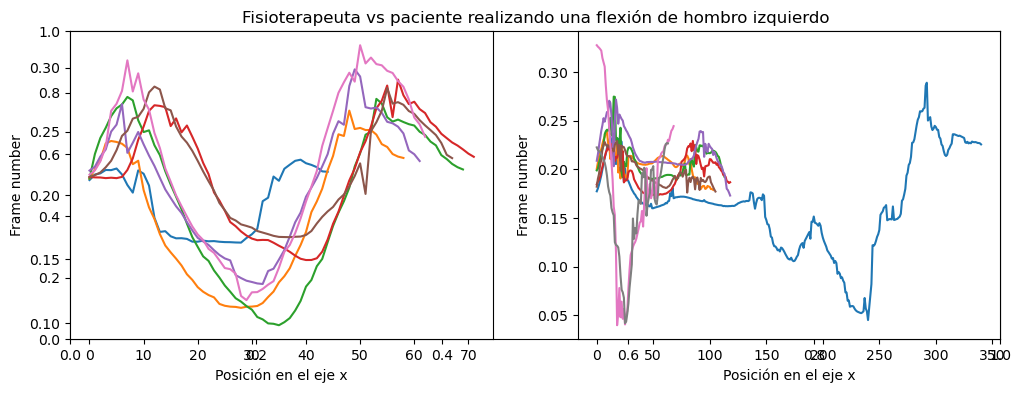

In [8]:
# creamos una gráfica para cada persona
fig = plt.figure(figsize=(12, 4))
plt.title('Fisioterapeuta vs paciente realizando una flexión de hombro izquierdo')
plt.subplot(1, 2, 1)
repetition_graph(persona_sana, 'WristRight', '3D_X')

plt.subplot(1, 2, 2)
repetition_graph(paciente_206, 'WristRight', '3D_X')

plt.show()

## 2. Numero de correctas e incorrectas (class imbalance)

* CorrectLabel: A value of 1 represents a gesture labeled as being correctly executed, while a value of 2 is for a gesture labeled as incorrect

QUE HACER CON CorrectLabel = 3

Text(0, 0.5, 'Number of Patients')

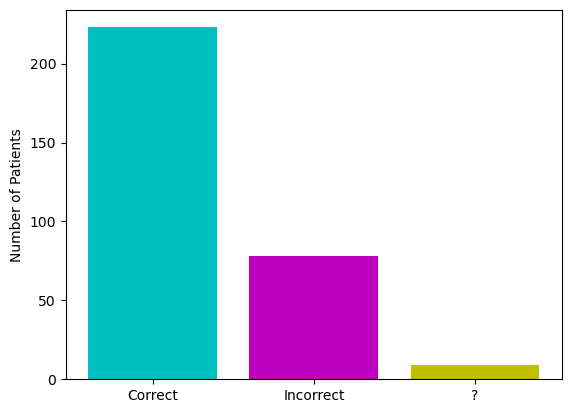

In [9]:
df_peque = df_data[['SubjectID', 'GestureLabel', 'CorrectLabel']].drop_duplicates().reset_index(drop=True)

df_peque = df_peque.groupby(['CorrectLabel']).count()
x = ["Correct", "Incorrect", "?"]
color =  ['c', 'm', 'y']
plt.bar(x, df_peque['GestureLabel'].values, color=color)
plt.ylabel('Number of Patients')

## 3. Calcular los ángulos

<div>
<img src="../images/gestures.png" width="500"/>
</div>

In [10]:
def calculate_angle(df: pd.DataFrame, joint_a: str, joint_b: str, joint_c: str):

    """
    Calcula los ángulos usando tres keypoints como referencia
    """

    # extraemos la posición de los keypoints 
    a = df.loc[df['JointName'] == joint_a, ['3D_X', '3D_Y']].to_numpy()[0]
    b = df.loc[df['JointName'] == joint_b, ['3D_X', '3D_Y']].to_numpy()[0]
    c = df.loc[df['JointName'] == joint_c, ['3D_X', '3D_Y']].to_numpy()[0]

    # convertir a numerico
    a = pd.to_numeric(a) #First
    b = pd.to_numeric(b) #Mid
    c = pd.to_numeric(c) #End


    # cacular los radianes y el angulo
    # los [1] representan las y y los [0] las x
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    # para tener un maximo de 180 grados
    if angle > 180.0:
        angle = 360 - angle

    return angle

Key point necesarios para calccular el ángulo de cada movimiento

In [22]:
groups = df_data.groupby(['SubjectID', 'GestureLabel'])

angle_data = []

for key, values in groups:

    n_rows = 25
    for i in range(0, n_rows, len(values)):
        keyPointsxFrame = values.iloc[i:i+n_rows]
        elbowAngleLeft = calculate_angle(keyPointsxFrame, 'ShoulderLeft', 'ElbowLeft', 'WristLeft')
        elbowAngleRight = calculate_angle(keyPointsxFrame, 'ShoulderRight', 'ElbowRight', 'WristRight')
        LeftArmAngle = calculate_angle(keyPointsxFrame, 'HipLeft', 'ShoulderLeft', 'ElbowLeft')
        RightArmAngle = calculate_angle(keyPointsxFrame, 'HipRight', 'ShoulderRight', 'ElbowRight')
        ArmsTogetherAngle = calculate_angle(keyPointsxFrame, 'SpineBase', 'SpineShoulder', 'WristLeft')
       
        angle_data.append({
            'SubjectID': key[0],
            'GestureLabel': key[1],
            'ElbowAngleLeft': elbowAngleLeft,
            'ElbowAngleRight': elbowAngleRight,
            'LeftArmAngle': LeftArmAngle,
            'RightArmAngle': RightArmAngle,
            'ArmsTogetherAngle': ArmsTogetherAngle
        })

df_angle = pd.DataFrame(angle_data)



In [23]:
df_angle.head()

,SubjectID,GestureLabel,ElbowAngleLeft,ElbowAngleRight,LeftArmAngle,RightArmAngle,ArmsTogetherAngle
0,101,0,177.953378,177.470786,23.174244,19.935830,25.940740
1,101,1,179.080756,177.561701,28.499426,26.112082,28.496483
2,101,2,171.819587,179.259072,26.058046,26.831654,25.510132
3,101,3,173.821219,178.589480,25.793500,26.534174,26.006091
4,101,4,167.589055,179.363698,26.620192,25.040901,24.454335


In [13]:
df_angle.to_csv('../csvFiles/angles.csv', index=False)

## 4. Ángulos a través de t

In [14]:
def angle_graph(df:pd.DataFrame, angle:str):
    """
    Crea una gráfica donde se representa el ángulo a través del tiempo (frames) de un paciente.
    Cada línea representa una repetición distinta.
    """
    groups = df.groupby("RepetitionNumber") # agrupa el dataframe según la repeticion
 
    for name, group in groups:
        valueAngle = group[angle].values
        plt.plot(valueAngle, label = "repetition "+ str(name))
        plt.xlabel("Angle")
        plt.ylabel("Frame number")